# Load image

num GPUs 0
Dimensions of input image: (3, 128, 128)


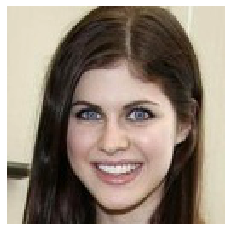

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from sklearn import linear_model

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time

#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '_128x128' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
#if dataset == 'celeba':
#    img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)
img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size



In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable
import torch.optim as optim

use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)


Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


# Construct latent vector z. Compute and visualize G(z)

In [ ]:
G = model.netG
z = torch.zeros(1,model.config.noiseVectorDim)
gen_image = G(z)



grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
# plt.show()

# Compressed sensing

## A=I. Recover G0 (naive)

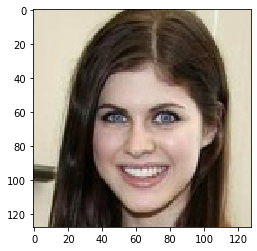

In [21]:
from torch.autograd import Variable
import torch.optim as optim

G = model.netG
mse = torch.nn.MSELoss()

#G0 = G(torch.zeros(1,model.config.noiseVectorDim))
G0 = img_var

z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
#gen_image = G(z)
grid = torchvision.utils.make_grid(G0.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
#plt.show()


def exp_lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=15, factor=0.7):
    """Decay learning rate by a factor of 0.5 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLR is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def fit(num_iter = 4000, lr_decay_epoch = 400):
    optimizer = optim.Adam([z], lr=0.1)
    for i in range(num_iter):
        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch=lr_decay_epoch, factor=0.9)
            
        #################
        def closure():
            optimizer.zero_grad()           
            x = G(z)
            loss = mse(x, G0)
            loss.backward(retain_graph=True)
            print('loss = {}'.format(loss))
            return loss

        loss = optimizer.step(closure)
    print('-' * 50)
    print('loss = {}'.format(loss))

In [ ]:
#optimizer = optim.Adam([z], lr=0.1)
#num_iter = 60
#lr_decay_epoch = 20


    #print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')

fit(num_iter = 4000, lr_decay_epoch = 400)

print('done')


LR is set to 0.1


loss = 0.8790583610534668
loss = 0.40549638867378235
loss = 0.16887180507183075
loss = 0.09575090557336807
loss = 0.09048890322446823
loss = 0.0953754410147667
loss = 0.09818398207426071
loss = 0.09891244769096375
loss = 0.0982244685292244
loss = 0.09688800573348999
loss = 0.09544643014669418
loss = 0.09414560347795486
loss = 0.09296771883964539
loss = 0.09173694998025894
loss = 0.09034836292266846
loss = 0.08885073661804199
loss = 0.08726624399423599
loss = 0.08568205684423447
loss = 0.08415275812149048
loss = 0.08266666531562805
loss = 0.08122298866510391
loss = 0.07988382130861282
loss = 0.07878661155700684
loss = 0.07790025323629379
loss = 0.07718496769666672
loss = 0.07655898481607437
loss = 0.07602420449256897
loss = 0.07548242807388306
loss = 0.07489240914583206
loss = 0.07422873377799988
loss = 0.07347813248634338
loss = 0.0726306214928627
loss = 0.07174039632081985
loss = 0.07082075625658035
loss = 0.06988140940666199
loss = 0.068984754383564
loss = 0.06815

tensor([[[[-1.6884, -1.6741, -1.6386,  ..., -0.2629, -0.2834, -0.3048],
          [-1.6307, -1.6262, -1.6094,  ..., -0.1881, -0.2079, -0.2739],
          [-1.6400, -1.6222, -1.6063,  ..., -0.1843, -0.1817, -0.1975],
          ...,
          [-1.5128, -1.4717, -1.5186,  ..., -1.6337, -1.6359, -1.6456],
          [-1.5111, -1.4930, -1.5626,  ..., -1.6371, -1.6467, -1.6421],
          [-1.4578, -1.4930, -1.5841,  ..., -1.6528, -1.6532, -1.6324]],

         [[-1.8123, -1.7900, -1.7697,  ..., -1.3986, -1.3411, -1.3836],
          [-1.7015, -1.7387, -1.7391,  ..., -1.3642, -1.3458, -1.4198],
          [-1.7210, -1.7319, -1.7296,  ..., -1.3457, -1.3499, -1.3918],
          ...,
          [-1.5392, -1.5001, -1.5619,  ..., -1.6463, -1.6447, -1.6670],
          [-1.5078, -1.5201, -1.5960,  ..., -1.6441, -1.6522, -1.6517],
          [-1.4435, -1.5389, -1.6242,  ..., -1.6504, -1.6361, -1.6185]],

         [[-1.7083, -1.6814, -1.6721,  ..., -1.2273, -1.1444, -1.2028],
          [-1.6377, -1.6542, -

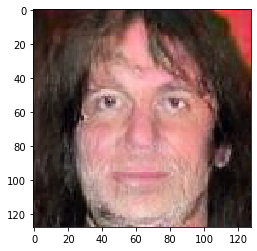

In [23]:


print(gen_image-G0)


In [ ]:
G = model.netG
mse = torch.nn.MSELoss()

G0 = G(torch.zeros(1,model.config.noiseVectorDim))
d_image = G0.numel()
x = G0.reshape(d_image)

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A
A = torch.randn(m_image, d_image)
y = torch.matmul(A,x)

x_var = torch.zeros(d_image)
y_var = torch.zeros(m_image)

z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
print('start')
# optimization min ||AG(z)-AG0||

for t in range(10):
    print('-' * 50)
    
    lr = 0.05
    v = x - lr*torch.matmul(A.transpose(), torch.matmul(A,x)-y)
    
    # minimize ||G(z)-v||
    optimizer = optim.Adam([z], lr=0.09)
    for i in range(10):
        optimizer.zero_grad()
        loss = mse(G(z), v)
        print(t, loss)
        loss.backward(retain_graph=True)
        optimizer.step()
        print('end epoch')

x_hat = G(z)
#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

In [ ]:
G = model.netG
mse = torch.nn.MSELoss()

G0 = G(torch.zeros(1,model.config.noiseVectorDim))
d_image = G0.numel()
x = G0.reshape(d_image)

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A
A = torch.randn(m_image, d_image)
y = torch.matmul(A,x)

# optimization min ||AG(z)-AG0||
z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
optimizer = optim.Adam([z], lr=0.09)
for t in range(10):
    print('-' * 50)
    optimizer.zero_grad()
    x_var = G(z).reshape(d_image)
    y_var = torch.matmul(A,x_var)
    loss = mse(y_var, y)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

x_hat = G(z)
#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
# plt.show()
#print(Ameas.shape)
# measurements : y = A*x
#img_var_meas = torch.matmul(Ameas_var,img_var.to(device).reshape(d_image,1))



In [ ]:
import time
import torch

t0 = time.time()

x = torch.randn(50000)
A = torch.randn(10000,50000)
y = torch.matmul(A,x)

t1 = time.time()
print('\ntime elapsed:',t1-t0)

In [ ]:
'''
optimizer = optim.Adam([z], lr=0.09)
for t in range(10):
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')
    
optimizer = optim.Adam([z], lr=0.06)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

optimizer = optim.Adam([z], lr=0.03)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

optimizer = optim.Adam([z], lr=0.01)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
'''